In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [65]:
data_train = pd.read_csv("data/train.csv")

In [66]:
data_train.drop(["id"], axis=1, inplace=True)

data_train.describe()

,age,balance,day,duration,campaign,pdays,previous,y
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,40.926395,1204.067397,16.117209,256.229144,2.577008,22.412733,0.298545,0.120651
std,10.098829,2836.096759,8.250832,272.555662,2.718514,77.319998,1.335926,0.325721
min,18.000000,-8019.000000,1.000000,1.000000,1.000000,-1.000000,0.000000,0.000000
25%,33.000000,0.000000,9.000000,91.000000,1.000000,-1.000000,0.000000,0.000000
50%,39.000000,634.000000,17.000000,133.000000,2.000000,-1.000000,0.000000,0.000000
75%,48.000000,1390.000000,21.000000,361.000000,3.000000,-1.000000,0.000000,0.000000
max,95.000000,99717.000000,31.000000,4918.000000,63.000000,871.000000,200.000000,1.000000


In [67]:
data_train.isna().any().value_counts()

False    17
Name: count, dtype: int64

## EDA on Numeric Features

=== Summary Statistics ===
                 age        balance       duration       campaign  \
count  750000.000000  750000.000000  750000.000000  750000.000000   
mean       40.926395    1204.067397     256.229144       2.577008   
std        10.098829    2836.096759     272.555662       2.718514   
min        18.000000   -8019.000000       1.000000       1.000000   
25%        33.000000       0.000000      91.000000       1.000000   
50%        39.000000     634.000000     133.000000       2.000000   
75%        48.000000    1390.000000     361.000000       3.000000   
max        95.000000   99717.000000    4918.000000      63.000000   

               pdays       previous  
count  750000.000000  750000.000000  
mean       22.412733       0.298545  
std        77.319998       1.335926  
min        -1.000000       0.000000  
25%        -1.000000       0.000000  
50%        -1.000000       0.000000  
75%        -1.000000       0.000000  
max       871.000000     200.000000  


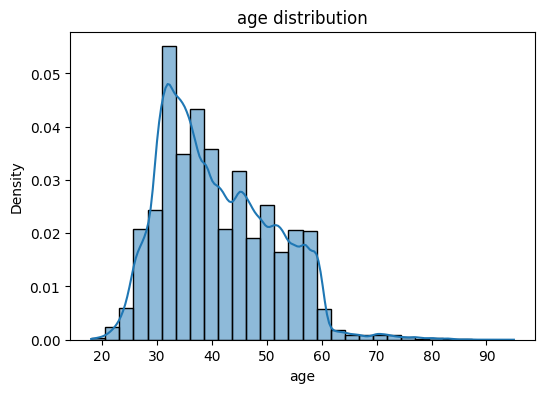

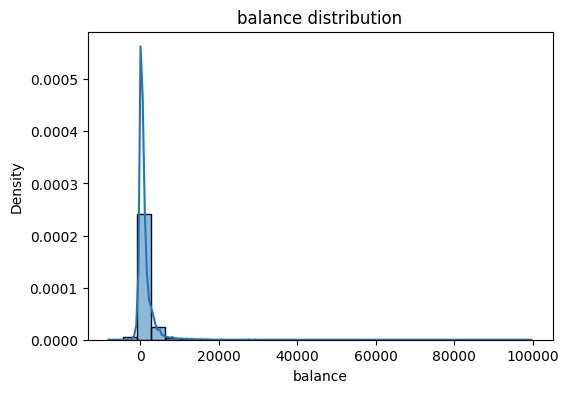

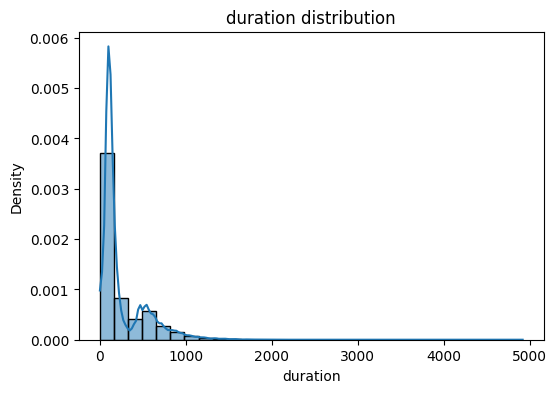

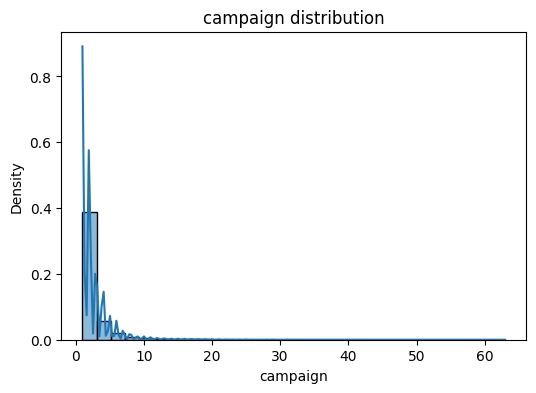

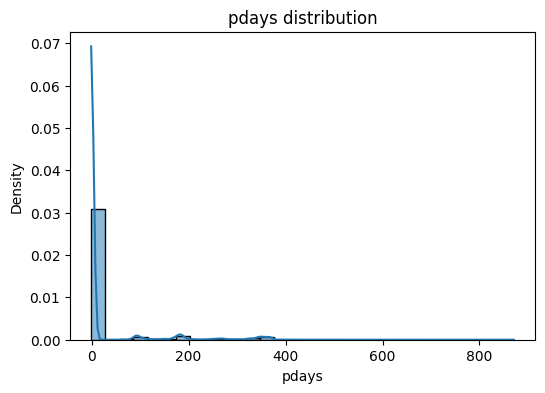

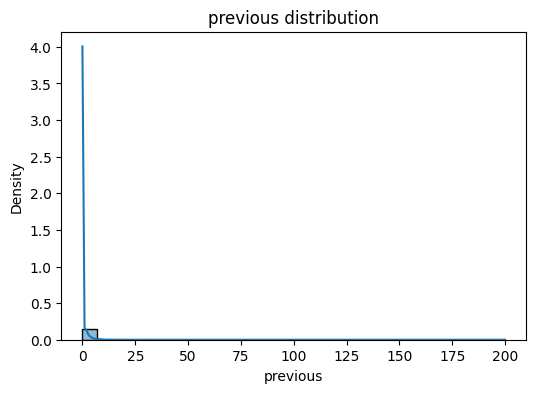

In [68]:

# 1. Specify the numeric columns
num_cols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']

# 2. Summary statistics
print("=== Summary Statistics ===")
print(data_train[num_cols].describe())

# 3. Plot histograms + KDEs
for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(data_train[col], kde=True, stat="density", bins=30)
    plt.title(f"{col} distribution")
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.show()

In [69]:

# 4. Outlier detection
outlier_info = {}
for col in num_cols:
    Q1 = data_train[col].quantile(0.25)
    Q3 = data_train[col].quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    mask_iqr = (data_train[col] < lower) | (data_train[col] > upper)
    pct_iqr = mask_iqr.mean() * 100
    
    z_scores = np.abs(stats.zscore(data_train[col].dropna()))
    mask_z = z_scores > 3
    pct_z = mask_z.mean() * 100
    
    outlier_info[col] = {
        'IQR_bounds': (lower, upper),
        '% outside IQR': pct_iqr,
        '% |z|>3': pct_z
    }

print("\n=== Outlier Summary ===")
for col, info in outlier_info.items():
    print(f"{col:>8}:  IQR outliers ~{info['% outside IQR']:.1f}%  |  Z outliers ~{info['% |z|>3']:.1f}%")




=== Outlier Summary ===
     age:  IQR outliers ~0.7%  |  Z outliers ~0.5%
 balance:  IQR outliers ~7.7%  |  Z outliers ~1.2%
duration:  IQR outliers ~6.1%  |  Z outliers ~1.8%
campaign:  IQR outliers ~5.4%  |  Z outliers ~2.0%
   pdays:  IQR outliers ~10.3%  |  Z outliers ~4.1%
previous:  IQR outliers ~10.3%  |  Z outliers ~1.6%


In [70]:
# Handling skew / outliers

# Log-transform (for right-skew)
lower_pct, upper_pct = data_train['balance'].quantile([0.01, 0.99])
data_train['balance_winsor'] = data_train['balance'].clip(lower=lower_pct, upper=upper_pct)
data_train.drop(columns=['balance'], axis=1, inplace=True)


In [71]:
data_train['pdays_never'] = (data_train['pdays'] == 999).astype(int)
#    — now 1 means “never contacted”, 0 means “was contacted at least once”

# 2. Clean up pdays for those who were contacted
#    Replace 999 with NaN so that any continuous transform (log, scaling) ignores the “never” cases
data_train['pdays_clean'] = data_train['pdays'].replace(999, np.nan)


# 4. Drop or archive the raw pdays if you no longer need it
data_train.drop(columns=['pdays'], inplace=True)

# ——— sanity check ———
data_train.head()

,age,job,marital,education,default,housing,loan,contact,day,month,duration,campaign,previous,poutcome,y,balance_winsor,pdays_never,pdays_clean
0,42,technician,married,secondary,no,no,no,cellular,25,aug,117,3,0,unknown,0,7,0,-1
1,38,blue-collar,married,secondary,no,no,no,unknown,18,jun,185,1,0,unknown,0,514,0,-1
2,36,blue-collar,married,secondary,no,yes,no,unknown,14,may,111,2,0,unknown,0,602,0,-1
3,27,student,single,secondary,no,yes,no,unknown,28,may,10,2,0,unknown,0,34,0,-1
4,26,technician,married,secondary,no,yes,no,cellular,3,feb,902,1,0,unknown,1,889,0,-1


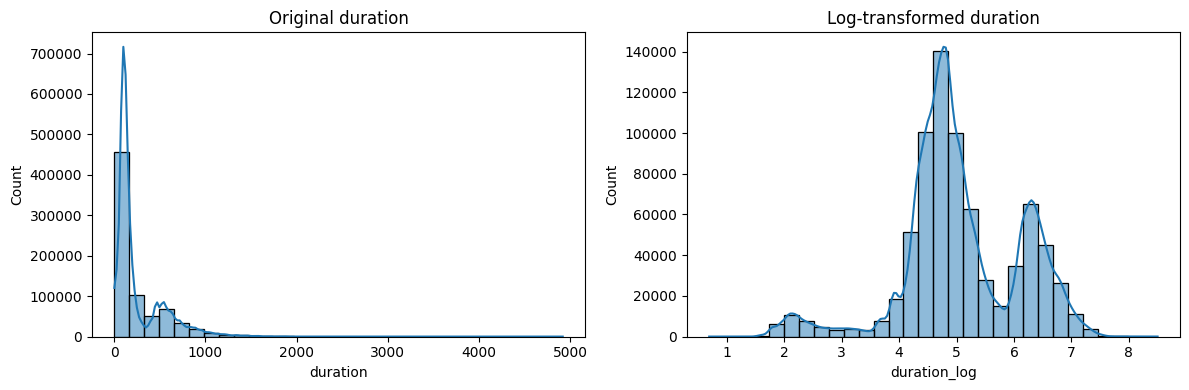

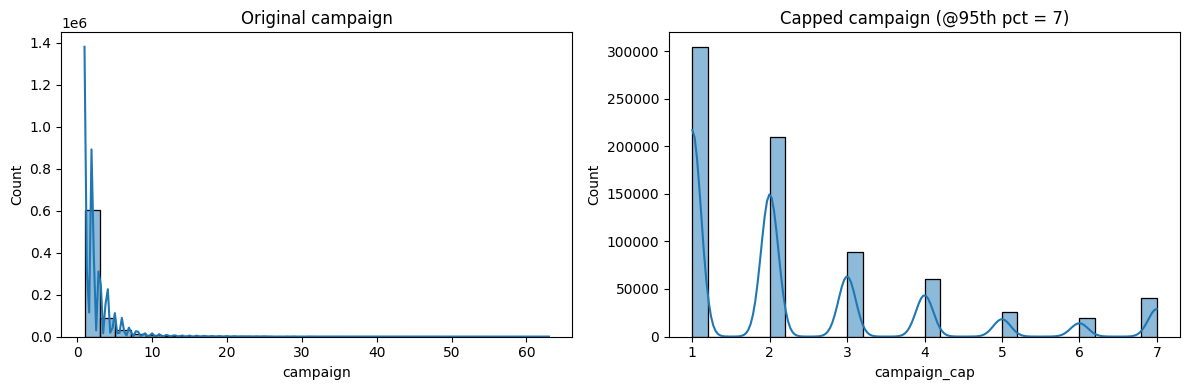

In [72]:
data_train['duration_log'] = np.log1p(data_train['duration'])

# (Optional) Quick before/after plot for 'duration'
fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.histplot(data_train['duration'], kde=True, ax=axes[0], bins=30)
axes[0].set_title("Original duration")
sns.histplot(data_train['duration_log'], kde=True, ax=axes[1], bins=30)
axes[1].set_title("Log-transformed duration")
plt.tight_layout()
plt.show()

# 2. Cap the 'campaign' column at its 95th percentile
cap_95 = data_train['campaign'].quantile(0.95)
data_train['campaign_cap'] = data_train['campaign'].clip(upper=cap_95)

# (Optional) Compare campaign distributions
fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.histplot(data_train['campaign'], kde=True, ax=axes[0], bins=30)
axes[0].set_title("Original campaign")
sns.histplot(data_train['campaign_cap'], kde=True, ax=axes[1], bins=30)
axes[1].set_title(f"Capped campaign (@95th pct = {cap_95:.0f})")
plt.tight_layout()
plt.show()

In [73]:
data_train.drop(columns=['campaign', 'duration'], axis = 1, inplace=True)

In [74]:
cap_val = 5
data_train['previous_cap'] = data_train['previous'].clip(upper=cap_val)

# 2. Bucket into (0), (1–3), (4+)
bins  = [-1, 0, 3, np.inf]      # note: -1 so that 0 goes in the first bin
labels = ['0', '1-3', '4+']
data_train['previous_bucket'] = pd.cut(data_train['previous'], bins=bins, labels=labels)

# 3. (Optional) One-hot encode the buckets
data_train = pd.get_dummies(data_train, columns=['previous_bucket'], prefix='prev', drop_first=False)

# 4. Drop the original column
data_train.drop(columns=['previous'], inplace=True)

In [75]:
data_train.head()

,age,job,marital,education,default,housing,loan,contact,day,month,...,y,balance_winsor,pdays_never,pdays_clean,duration_log,campaign_cap,previous_cap,prev_0,prev_1-3,prev_4+
0,42,technician,married,secondary,no,no,no,cellular,25,aug,...,0,7,0,-1,4.770685,3,0,True,False,False
1,38,blue-collar,married,secondary,no,no,no,unknown,18,jun,...,0,514,0,-1,5.225747,1,0,True,False,False
2,36,blue-collar,married,secondary,no,yes,no,unknown,14,may,...,0,602,0,-1,4.718499,2,0,True,False,False
3,27,student,single,secondary,no,yes,no,unknown,28,may,...,0,34,0,-1,2.397895,2,0,True,False,False
4,26,technician,married,secondary,no,yes,no,cellular,3,feb,...,1,889,0,-1,6.805723,1,0,True,False,False


## Categorical Feature Engineering

In [76]:
cat_cols = [
    "job", "marital", "education",           # socio-demographic
    "default", "housing", "loan",            # binary credit flags
    "contact", "month", "poutcome"           # campaign metadata
]


In [77]:
# Basic completeness & cardinality summary
data_train[cat_cols].agg(
    ["nunique", lambda s: s.isna().mean()*100],
).T.rename(columns={"<lambda_0>":"%_missing"})


,nunique,<lambda>
job,12.0,0.0
marital,3.0,0.0
education,4.0,0.0
default,2.0,0.0
housing,2.0,0.0
loan,2.0,0.0
contact,3.0,0.0
month,12.0,0.0
poutcome,4.0,0.0


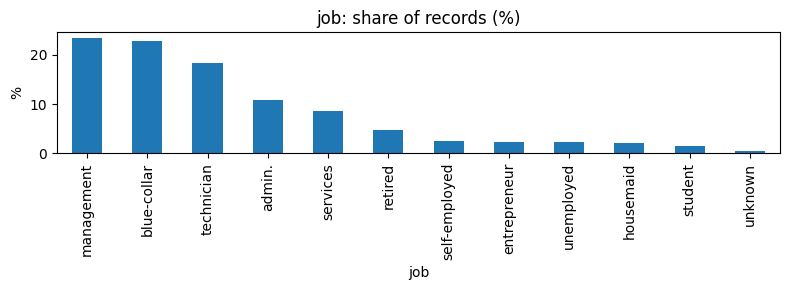

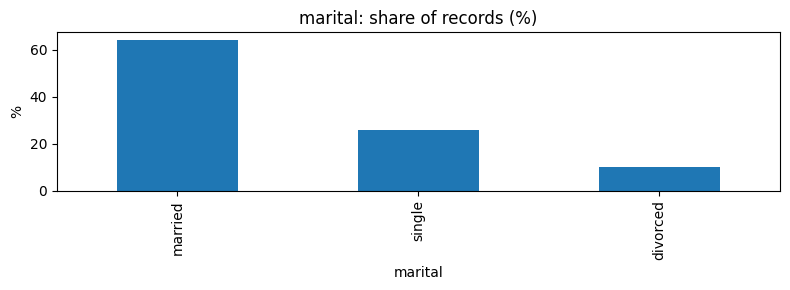

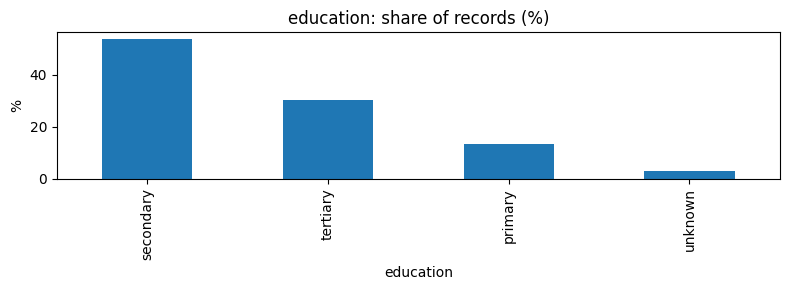

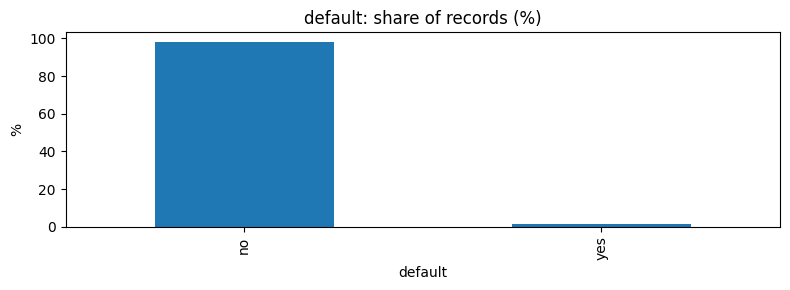

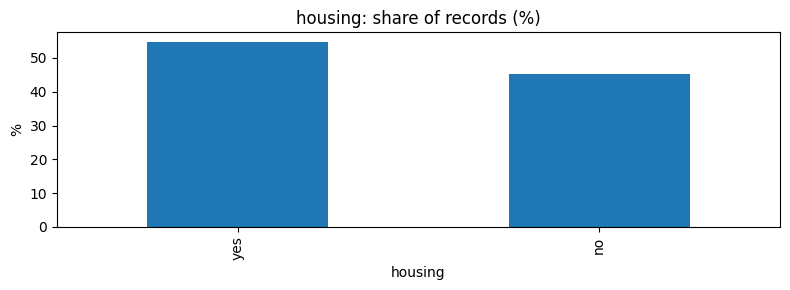

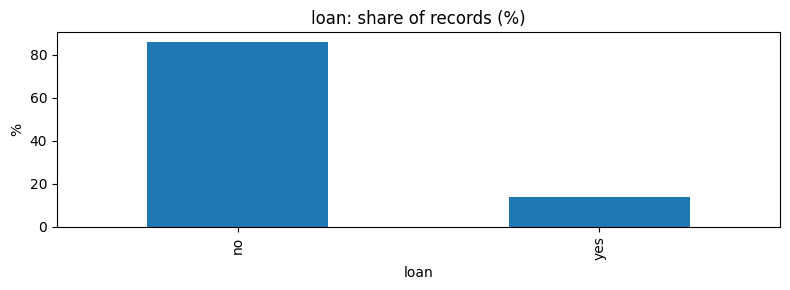

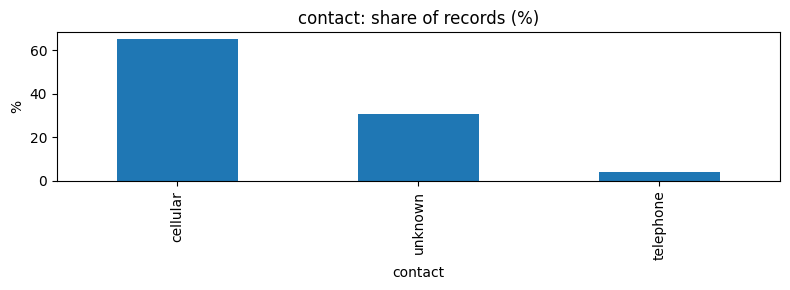

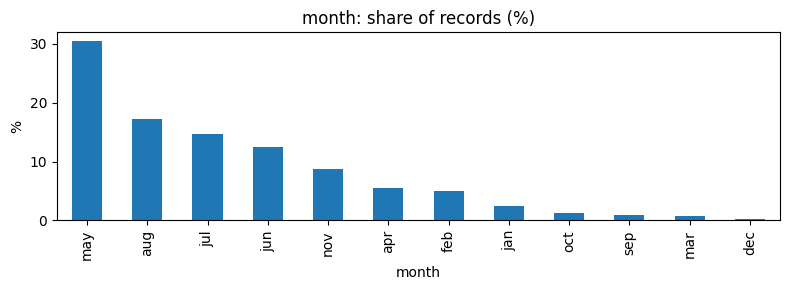

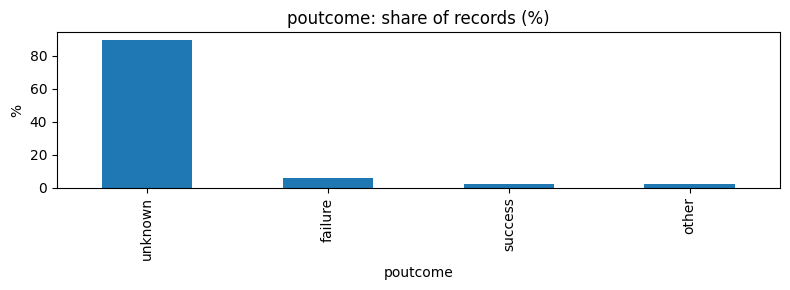

In [78]:
import matplotlib.pyplot as plt
for col in cat_cols:
    vc = data_train[col].value_counts(dropna=False, normalize=True)*100
    plt.figure(figsize=(8,3))
    vc.plot.bar()
    plt.title(f"{col}: share of records (%)")
    plt.ylabel("%")
    plt.tight_layout()
    plt.show()


In [79]:
def combine_rare(series, cutoff=0.01):
    freq = series.value_counts(normalize=True)
    rare_levels = freq[freq < cutoff].index
    return series.where(~series.isin(rare_levels), other="__OTHER__")

for col in ["job", "education", "poutcome"]:
    data_train[col] = combine_rare(data_train[col])


In [80]:
ed_map = {"unknown":np.nan,"primary":1,"secondary":2,"tertiary":3}
data_train["education_ord"]=data_train["education"].map(ed_map)
data_train.drop(columns=["education"], axis = 1, inplace=True)

In [81]:
month_map = {m:i for i,m in enumerate(["jan","feb","mar","apr","may","jun","jul","aug","sep","oct","nov","dec"],start=1)}
data_train["month_num"]=data_train["month"].map(month_map)
data_train["month_sin"]=np.sin(2*np.pi*data_train["month_num"]/12)
data_train.drop(columns=["month"], axis = 1, inplace=True)

In [82]:
bin_cols=["default","housing","loan"]
data_train[bin_cols]=data_train[bin_cols].replace({"yes":1,"no":0})
data_train.drop(columns=bin_cols, axis = 1, inplace=True)

/tmp/ipykernel_4800/2431010375.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_train[bin_cols]=data_train[bin_cols].replace({"yes":1,"no":0})


## One Hot Encoding

In [83]:
nominal_cols = ["job", "marital", "contact", "poutcome"]
data_train = pd.get_dummies(
    data_train,
    columns=nominal_cols,
    prefix=nominal_cols,
    drop_first=True,          # avoids dummy trap
    dtype="int8"              # memory-friendly
)

In [84]:
X_train = data_train.drop(columns=["y"], axis=1)
y_train = data_train["y"].replace({"yes":1,"no":0})

In [ ]:
X_train.head()

,age,day,balance_winsor,pdays_never,pdays_clean,duration_log,campaign_cap,previous_cap,prev_0,prev_1-3,...,job_student,job_technician,job_unemployed,marital_married,marital_single,contact_telephone,contact_unknown,poutcome_other,poutcome_success,poutcome_unknown
0,42,25,7,0,-1,4.770685,3,0,True,False,...,0,1,0,1,0,0,0,0,0,1
1,38,18,514,0,-1,5.225747,1,0,True,False,...,0,0,0,1,0,0,1,0,0,1
2,36,14,602,0,-1,4.718499,2,0,True,False,...,0,0,0,1,0,0,1,0,0,1
3,27,28,34,0,-1,2.397895,2,0,True,False,...,1,0,0,0,1,0,1,0,0,1
4,26,3,889,0,-1,6.805723,1,0,True,False,...,0,1,0,1,0,0,0,0,0,1


: 

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=42, n_jobs=-1,  n_estimators=1000)
clf.fit(X_train, y_train)

In [ ]:
feature_importances = pd.DataFrame(clf.feature_importances_)
feature_names = pd.DataFrame(X_train.columns)

feature_importance_summary = pd.concat([feature_names, feature_importances], axis = 1)
feature_importance_summary.columns = ["input_variables", "feature_importance"]
feature_importance_summary.sort_values(by="feature_importance", inplace=True)

In [ ]:
plt.barh(feature_importance_summary["input_variables"], feature_importance_summary["feature_importance"])
plt.title("Random Forest Feature Importance")
plt.xlabel("Feature Importance") 
plt.tight_layout()
plt.show()